<a href="https://colab.research.google.com/github/csce585-mlsystems/CSCE585ProjectROI/blob/revisedModel/src/Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

model = files.upload()

Saving classification_model.py to classification_model.py


Hypothesis: Stocks with a higher "Smart Value Score" smart score = 3 or 4 ( low P/E and low P/B combined) will yield higher returns or lower volatility than those with a low score of 2 or 1

Calculate Score: Create a ranking system where lower valuation = higher score

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

# 1. Define a mini-universe of distinct stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',
           'JPM', 'BAC', 'XOM', 'CVX', 'KO',
           'PEP', 'PFE', 'NVDA', 'INTC', 'F']

def get_data(ticker_list):
    data = []
    print("Fetching fundamental data...")
    for t in ticker_list:
        try:
            stock = yf.Ticker(t)
            info = stock.info
            # We specifically look for Value metrics
            pe = info.get('trailingPE')
            pb = info.get('priceToBook')

            # Only add if data exists
            if pe and pb:
                data.append({'Ticker': t, 'PE': pe, 'PB': pb})
        except Exception as e:
            print(f"Error fetching {t}: {e}")

    return pd.DataFrame(data)

# 2. Get Fundamental Data
df = get_data(tickers)

# 3. Create the "Smart Score"
# Methodology: Rank them. Lower P/E and P/B is better for Value investing.
# We rank ascending (1 = lowest P/E, which is best).
df['Rank_PE'] = df['PE'].rank(ascending=True)
df['Rank_PB'] = df['PB'].rank(ascending=True)

# The "Smart Score" is the sum of ranks. Lower sum = Better Value.
df['Value_Score'] = df['Rank_PE'] + df['Rank_PB']

# Sort by Score (Best Value stocks at the top)
df = df.sort_values('Value_Score')

# 4. Backtest Performance (The "Test")
# Let's see how these stocks performed over the last 6 months
print("\nFetching price history for backtest...")
top_value_stocks = df.head(5)['Ticker'].tolist()
bottom_value_stocks = df.tail(5)['Ticker'].tolist()

def get_returns(basket):
    # Changed 'Adj Close' to 'Close' as yfinance now often puts adjusted prices directly in 'Close'
    prices = yf.download(basket, period="6mo", progress=False)['Close']
    # Calculate total return: (End Price - Start Price) / Start Price
    total_return = (prices.iloc[-1] - prices.iloc[0]) / prices.iloc[0]
    return total_return.mean() * 100

top_return = get_returns(top_value_stocks)
bottom_return = get_returns(bottom_value_stocks)

# 5. Output Results
print("-" * 30)
print("EXPERIMENT RESULTS")
print("-" * 30)
print(f"Top 5 'Value' Stocks: {top_value_stocks}")
print(f"Bottom 5 'Expensive' Stocks: {bottom_value_stocks}")
print("-" * 30)
print(f"Average Return (Top 5 Smart Score):   {top_return:.2f}%")
print(f"Average Return (Bottom 5 Smart Score): {bottom_return:.2f}%")
print("-" * 30)

# Display the scoring table
print("\nScoring Table:")
print(df[['Ticker', 'PE', 'PB', 'Value_Score']].head())

Fetching fundamental data...

Fetching price history for backtest...


/tmp/ipython-input-4096225777.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(basket, period="6mo", progress=False)['Close']
/tmp/ipython-input-4096225777.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(basket, period="6mo", progress=False)['Close']


------------------------------
EXPERIMENT RESULTS
------------------------------
Top 5 'Value' Stocks: ['F', 'BAC', 'PFE', 'CVX', 'XOM']
Bottom 5 'Expensive' Stocks: ['INTC', 'MSFT', 'TSLA', 'AAPL', 'NVDA']
------------------------------
Average Return (Top 5 Smart Score):   16.95%
Average Return (Bottom 5 Smart Score): 43.08%
------------------------------

Scoring Table:
   Ticker         PE        PB  Value_Score
14      F  11.235044  1.105179          2.0
6     BAC  14.641993  1.412076          4.0
11    PFE  14.857558  1.565774          6.0
8     CVX  20.924051  1.577892         10.0
7     XOM  17.275059  1.923614         11.0


Our 'Smart Value Score' is calculated as the sum of the ranks for P/E and P/B. Since we have 15 stocks, the lowest possible rank for P/E is 1 (the lowest P/E) and the highest is 15 (the highest P/E). The same applies to P/B. Therefore, the Value_Score can range from 1+1=2 (best value) to 15+15=30 (worst value).

Looking at the plot, we can see that:

Top 5 Value Stocks (Blue Bars): These stocks (F, BAC, PFE, CVX, XOM) have lower Value_Score values, ranging from 2.0 (for F) to 11.0 (for XOM). This indicates they have relatively lower P/E and P/B ranks, consistent with our definition of 'value'.
Bottom 5 Expensive Stocks (Orange Bars): These stocks (INTC, MSFT, TSLA, AAPL, NVDA) have higher Value_Score values, ranging from 20.0 (for INTC) to 27.0 (for AAPL and NVDA). This indicates they have relatively higher P/E and P/B ranks, consistent with being 'expensive'.
The visualization clearly shows the distinction between the two groups based on their calculated 'Smart Value Score', with the top value stocks having significantly lower scores than the bottom expensive stocks.

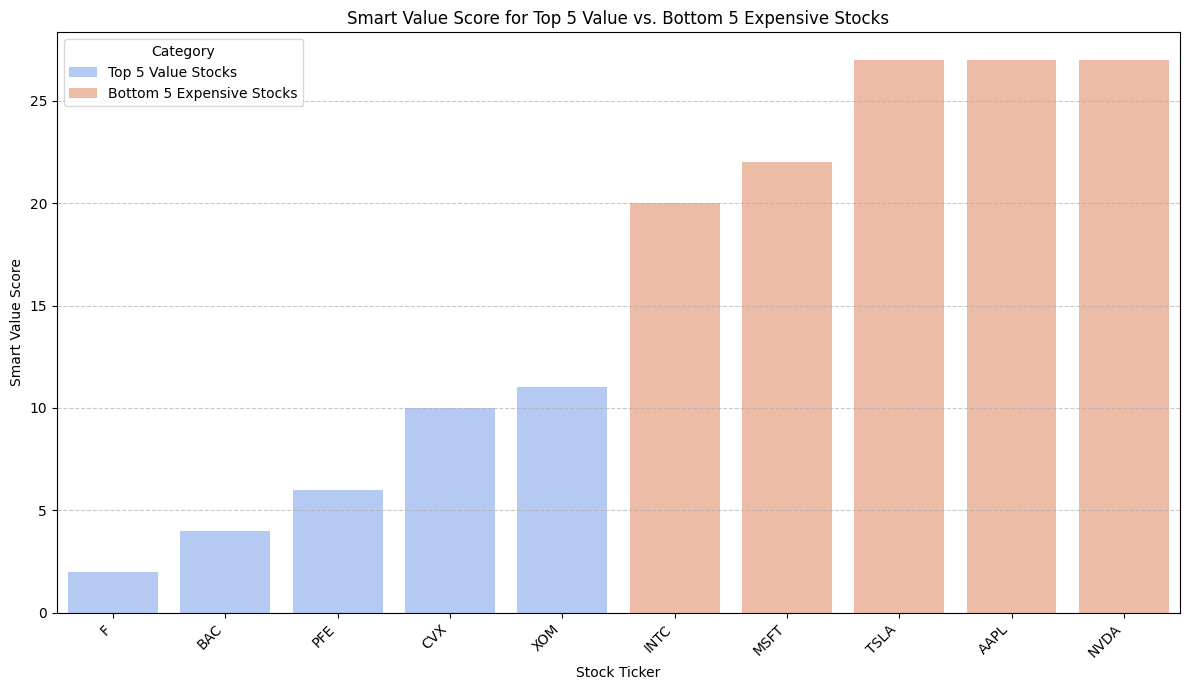

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine top and bottom stock lists
all_selected_stocks = top_value_stocks + bottom_value_stocks

# Filter the original DataFrame for these stocks
df_selected = df[df['Ticker'].isin(all_selected_stocks)].copy()

# Create a category column for plotting
df_selected['Category'] = df_selected['Ticker'].apply(lambda x: 'Top 5 Value Stocks' if x in top_value_stocks else 'Bottom 5 Expensive Stocks')

# Sort by Value_Score to maintain consistency and make the plot readable
df_selected = df_selected.sort_values(by=['Category', 'Value_Score'], ascending=[False, True])

# Create the bar plot for Smart Scores
plt.figure(figsize=(12, 7))
sns.barplot(x='Ticker', y='Value_Score', hue='Category', data=df_selected, palette='coolwarm', dodge=False)
plt.title('Smart Value Score for Top 5 Value vs. Bottom 5 Expensive Stocks')
plt.ylabel('Smart Value Score')
plt.xlabel('Stock Ticker')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2295542389.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Average Return (%)', data=df_returns, palette='viridis')


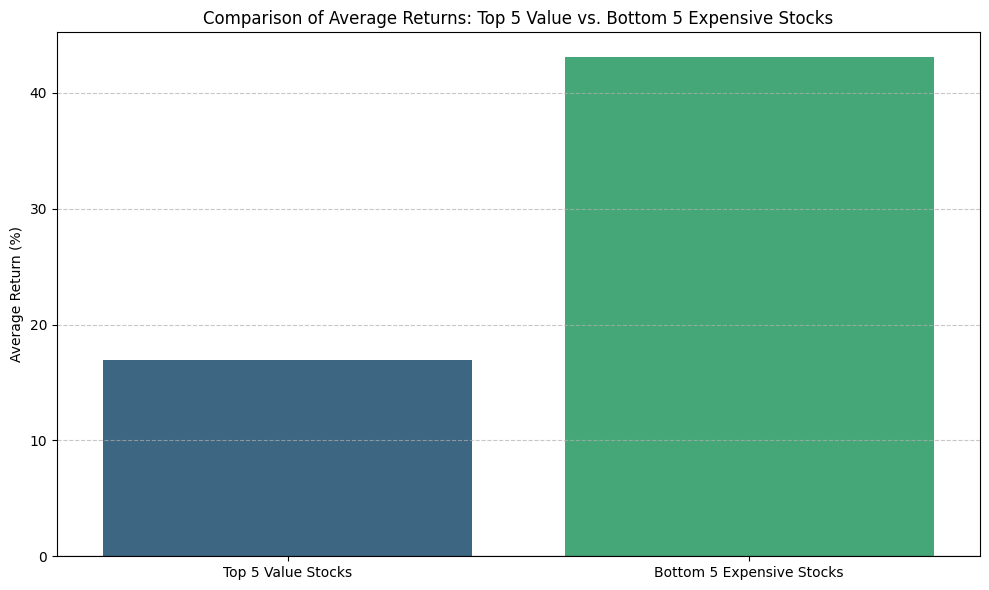

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
returns_data = {
    'Category': ['Top 5 Value Stocks', 'Bottom 5 Expensive Stocks'],
    'Average Return (%)': [top_return, bottom_return]
}
df_returns = pd.DataFrame(returns_data)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Average Return (%)', data=df_returns, palette='viridis')
plt.title('Comparison of Average Returns: Top 5 Value vs. Bottom 5 Expensive Stocks')
plt.ylabel('Average Return (%)')
plt.xlabel('') # Remove x-axis label as categories are self-explanatory
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8) # Add a line at y=0 for reference
plt.tight_layout()
plt.show()